# 01 — Exploratory Data Analysis: Raw Data

This notebook profiles the raw `workcomp_extract.csv` dataset to understand:
- Data shape, column types, and memory usage
- Missing values and data quality issues
- Material type code distributions
- Temporal coverage and gaps
- District/section code patterns
- Tonnage distributions and outliers

**Note:** We load a sample for speed since the full CSV is 2.3GB / 7.1M rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

import sys
sys.path.insert(0, str(Path.cwd().parent))
from src.config import RAW_CSV, MATERIAL_CODES, PRIMARY_STREAMS, BOROUGH_PREFIXES

## 1. Load a Sample

In [2]:
# Read first 500k rows for quick profiling
df_sample = pd.read_csv(RAW_CSV, nrows=500_000)
print(f"Sample shape: {df_sample.shape}")
print(f"Full file: ~7.1M rows")
df_sample.head()

/var/folders/hq/lzl21s154sjdtgsp2dpr41y80000gp/T/ipykernel_44276/3567225374.py:2: DtypeWarning: Columns (0: exception code, 1: authorized name, 2: entry name, 3: relaycheck) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sample = pd.read_csv(RAW_CSV, nrows=500_000)


Sample shape: (500000, 42)
Full file: ~7.1M rows


,Truck_ID,Collection_Date,Shift_ID,HQ_Code,Zone_Code,District_Code,Section_Code,Route_Code,Material_Type_Code,Total_Collection_Hours,...,exception code,authorized name,authorized badge,entry name,entry badge,DumpDate,DumpTime,relaycheck,Bin_Number,Finish_Trucks
0,25CN319,2003-06-30 00:00:00,3,BCCHQ,QWBO,QW09,QW093,QW093M3,1,16.0,...,,,0.0,,0.0,2003-07-01 00:00:00,0.0,NaN,2,1.0000
1,25CF072,2003-06-30 00:00:00,3,BCCHQ,QWBO,QW09,QW093,QW093M1,1,16.0,...,,,0.0,,0.0,2003-07-03 00:00:00,1.0,NaN,2,1.0000
2,25CM098,2003-06-30 00:00:00,2,BCCHQ,QWBO,QW09,QW093,QW093M1,47,8.0,...,,,0.0,,0.0,2003-06-30 00:00:00,18.0,NaN,2,0.5000
3,25CN245,2003-06-30 00:00:00,3,BCCHQ,QWBO,QW06,QW061,QW061M4,1,5.0,...,,,0.0,,0.0,2003-07-01 00:00:00,3.0,NaN,2,0.3125
4,25CM236,2003-06-30 00:00:00,3,BCCHQ,SIBO,SI01,SI011,SI011M2,77,2.0,...,,,0.0,,0.0,2003-07-02 00:00:00,9.0,NaN,2,0.1250


## 2. Column Profiling

In [3]:
# Data types and memory
print("=== Data Types ===")
print(df_sample.dtypes)
print(f"\nMemory usage: {df_sample.memory_usage(deep=True).sum() / 1e6:.1f} MB")

=== Data Types ===
Truck_ID                      str
Collection_Date               str
Shift_ID                    int64
HQ_Code                       str
Zone_Code                     str
District_Code                 str
Section_Code                  str
Route_Code                    str
Material_Type_Code          int64
Total_Collection_Hours    float64
Total_Lost_Time_Hours     float64
Reg_Total_Shift_Hours     float64
Adj_Total_Shift_Hours     float64
Relay_Hours               float64
Overtime_Hours            float64
Tons_Collected            float64
Tons_Uncollected          float64
Lost_Time_Code_1          float64
Lost_Time_Hours_1         float64
Lost_Time_Code_2          float64
Lost_Time_Hours_2         float64
Start_Trucks                int64
Tag_Code                      str
Dump_Time_Stamp               str
Scale_ID                      str
Load_Number                 int64
Net_Weight                float64
Dump_Fraction             float64
Claim_Location               

In [4]:
# Missing values
missing = df_sample.isnull().sum()
missing_pct = (missing / len(df_sample) * 100).round(2)
missing_report = pd.DataFrame({'count': missing, 'pct': missing_pct})
print("=== Missing Values ===")
print(missing_report[missing_report['count'] > 0].sort_values('pct', ascending=False))

=== Missing Values ===
                        count     pct
Lost_Time_Code_2       499991  100.00
Lost_Time_Code_1       498470   99.69
exception code         497615   99.52
authorized name        497615   99.52
authorized badge       497615   99.52
entry name             497615   99.52
entry badge            497615   99.52
Tag_Code               495822   99.16
Dump_Time_Stamp          8191    1.64
DumpDate                 8191    1.64
DumpTime                 8191    1.64
relaycheck               2385    0.48
Material_Out_Midnight     609    0.12
Tons_Collected             19    0.00
Dump_Fraction              19    0.00


In [5]:
# Unique values per column
print("=== Unique Value Counts ===")
for col in df_sample.columns:
    print(f"  {col}: {df_sample[col].nunique()}")

=== Unique Value Counts ===
  Truck_ID: 2471
  Collection_Date: 286
  Shift_ID: 3
  HQ_Code: 3
  Zone_Code: 11
  District_Code: 69
  Section_Code: 253
  Route_Code: 8201
  Material_Type_Code: 44
  Total_Collection_Hours: 101
  Total_Lost_Time_Hours: 44
  Reg_Total_Shift_Hours: 82
  Adj_Total_Shift_Hours: 82
  Relay_Hours: 377
  Overtime_Hours: 85
  Tons_Collected: 2023
  Tons_Uncollected: 687
  Lost_Time_Code_1: 15
  Lost_Time_Hours_1: 44
  Lost_Time_Code_2: 4
  Lost_Time_Hours_2: 5
  Start_Trucks: 2
  Tag_Code: 6
  Dump_Time_Stamp: 396973
  Scale_ID: 75
  Load_Number: 9669
  Net_Weight: 2041
  Dump_Fraction: 24836
  Claim_Location: 68
  Backlog_Truck: 2
  Material_Out_Midnight: 242
  Dumps_Onshift: 2566
  exception code: 1
  authorized name: 1
  authorized badge: 1
  entry name: 1
  entry badge: 1
  DumpDate: 274
  DumpTime: 24
  relaycheck: 1
  Bin_Number: 2
  Finish_Trucks: 84


## 3. Material Type Code Analysis

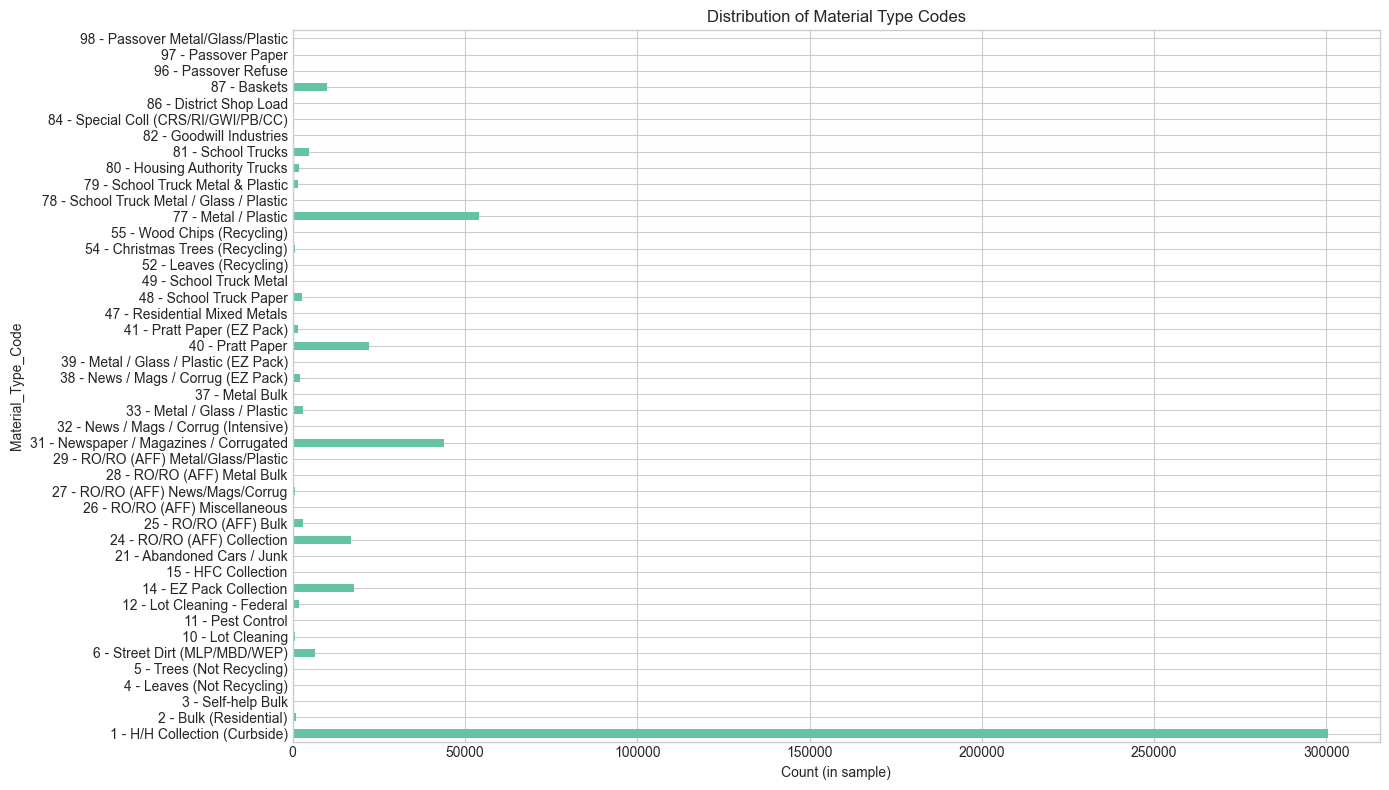


Top 10 material types:
Material_Type_Code
1 - H/H Collection (Curbside)    300504
2 - Bulk (Residential)             1014
3 - Self-help Bulk                   25
4 - Leaves (Not Recycling)           97
5 - Trees (Not Recycling)             5
6 - Street Dirt (MLP/MBD/WEP)      6390
10 - Lot Cleaning                   775
11 - Pest Control                   484
12 - Lot Cleaning - Federal        1933
14 - EZ Pack Collection           17890
Name: count, dtype: int64


In [6]:
# Distribution of material type codes
mat_counts = df_sample['Material_Type_Code'].value_counts().sort_index()
mat_counts_named = mat_counts.rename(index=lambda x: f"{x} - {MATERIAL_CODES.get(int(x), 'Unknown')}")

fig, ax = plt.subplots(figsize=(14, 8))
mat_counts_named.plot(kind='barh', ax=ax)
ax.set_xlabel('Count (in sample)')
ax.set_title('Distribution of Material Type Codes')
plt.tight_layout()
plt.show()

print("\nTop 10 material types:")
print(mat_counts_named.head(10))

In [7]:
# Primary streams share
primary_mask = df_sample['Material_Type_Code'].isin(list(PRIMARY_STREAMS.keys()))
print(f"Primary streams (Refuse/Paper/MGP): {primary_mask.sum():,} ({primary_mask.mean():.1%} of sample)")
for code, name in PRIMARY_STREAMS.items():
    n = (df_sample['Material_Type_Code'] == code).sum()
    print(f"  {name} (code {code}): {n:,} ({n/len(df_sample):.1%})")

Primary streams (Refuse/Paper/MGP): 347,343 (69.5% of sample)
  Refuse (code 1): 300,504 (60.1%)
  Paper (code 31): 43,924 (8.8%)
  MGP (code 33): 2,915 (0.6%)


## 4. Temporal Coverage

Date range: 2003-06-30 00:00:00 to 2004-04-10 00:00:00
Null dates: 0


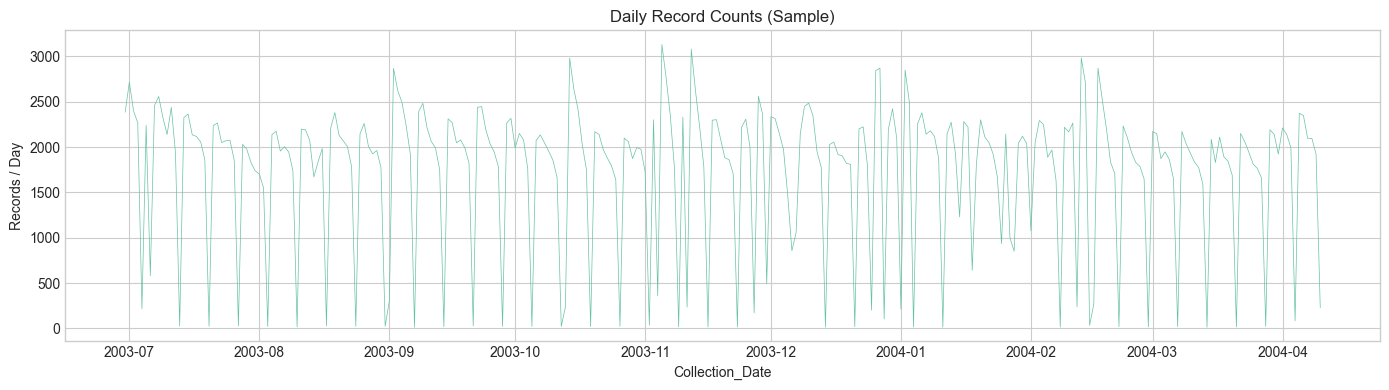

In [8]:
df_sample['Collection_Date'] = pd.to_datetime(df_sample['Collection_Date'], errors='coerce')

print(f"Date range: {df_sample['Collection_Date'].min()} to {df_sample['Collection_Date'].max()}")
print(f"Null dates: {df_sample['Collection_Date'].isna().sum()}")

# Daily record counts
daily_counts = df_sample.groupby(df_sample['Collection_Date'].dt.date).size()

fig, ax = plt.subplots(figsize=(14, 4))
daily_counts.plot(ax=ax, linewidth=0.5)
ax.set_ylabel('Records / Day')
ax.set_title('Daily Record Counts (Sample)')
plt.tight_layout()
plt.show()

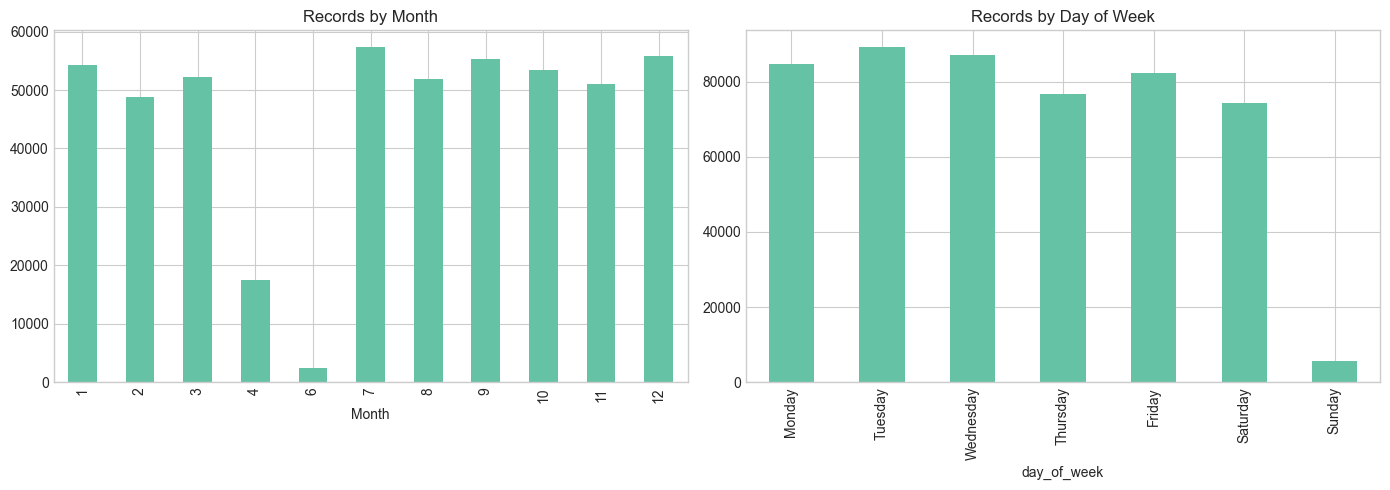

In [9]:
# Monthly patterns
df_sample['month'] = df_sample['Collection_Date'].dt.month
df_sample['year'] = df_sample['Collection_Date'].dt.year
df_sample['day_of_week'] = df_sample['Collection_Date'].dt.day_name()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_sample.groupby('month').size().plot(kind='bar', ax=axes[0])
axes[0].set_title('Records by Month')
axes[0].set_xlabel('Month')

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_sample.groupby('day_of_week').size().reindex(dow_order).plot(kind='bar', ax=axes[1])
axes[1].set_title('Records by Day of Week')

plt.tight_layout()
plt.show()

## 5. Geographic Codes

In [10]:
# Clean whitespace
for col in ['District_Code', 'Section_Code', 'Truck_ID']:
    df_sample[col] = df_sample[col].astype(str).str.strip()

print(f"Districts: {df_sample['District_Code'].nunique()}")
print(f"Sections: {df_sample['Section_Code'].nunique()}")

# Borough extraction
def get_borough(code):
    for prefix, borough in BOROUGH_PREFIXES.items():
        if code.startswith(prefix):
            return borough
    return 'Other'

df_sample['borough'] = df_sample['District_Code'].apply(get_borough)
print("\nRecords by borough:")
print(df_sample['borough'].value_counts())

Districts: 69
Sections: 253

Records by borough:
borough
Queens           153802
Brooklyn         149919
Other             86823
Bronx             63859
Staten Island     45451
Manhattan           146
Name: count, dtype: int64


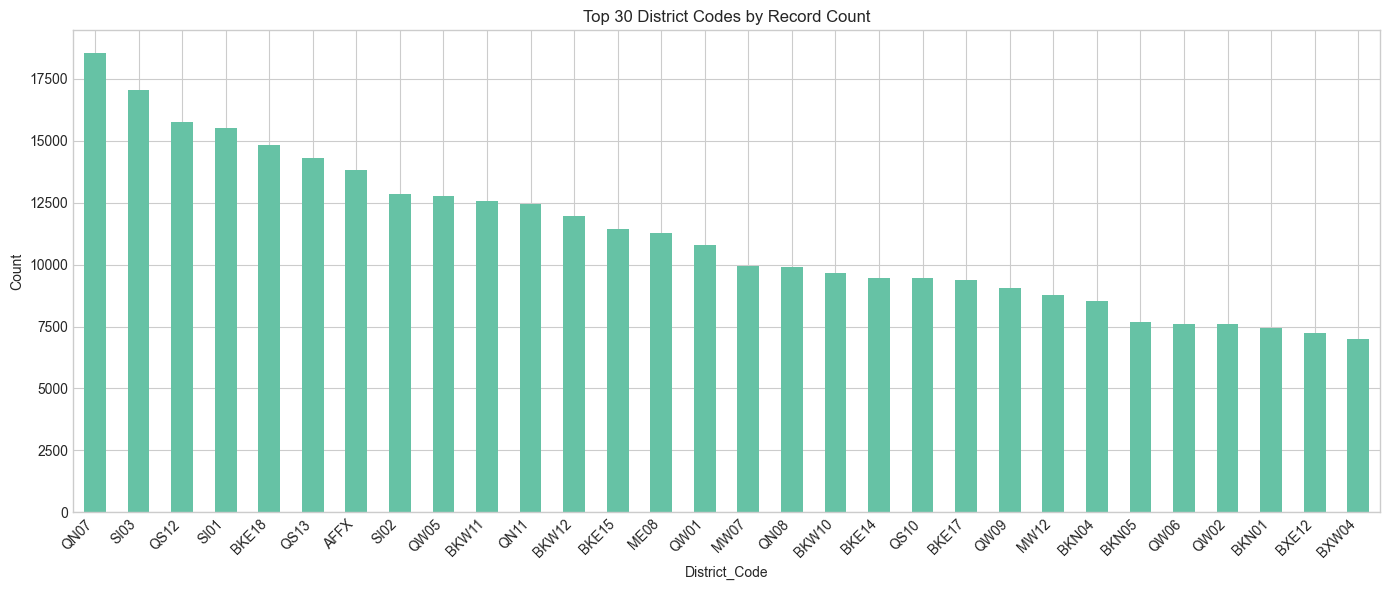

In [11]:
# District codes breakdown
fig, ax = plt.subplots(figsize=(14, 6))
df_sample['District_Code'].value_counts().head(30).plot(kind='bar', ax=ax)
ax.set_title('Top 30 District Codes by Record Count')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Tonnage Distribution

=== Tons_Collected Summary ===
count    499981.000000
mean          6.429822
std           4.121054
min           0.000000
25%           2.600000
50%           6.210000
75%           9.960000
max          29.290000
Name: Tons_Collected, dtype: float64

Zero tons: 8,873 (1.8%)
Negative tons: 0


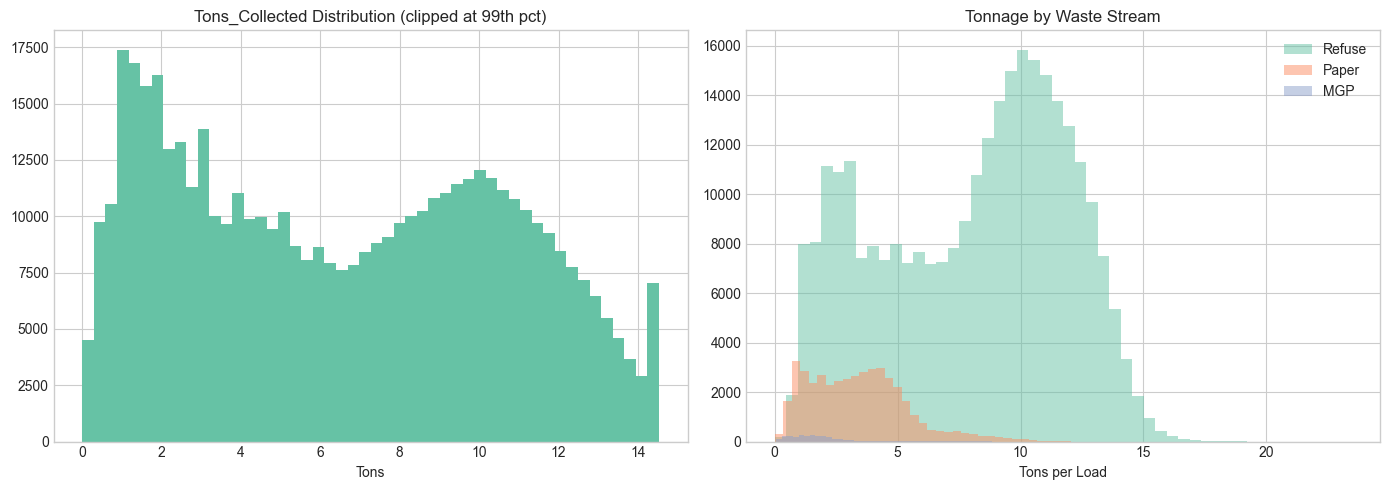

In [12]:
print("=== Tons_Collected Summary ===")
print(df_sample['Tons_Collected'].describe())

print(f"\nZero tons: {(df_sample['Tons_Collected'] == 0).sum():,} ({(df_sample['Tons_Collected'] == 0).mean():.1%})")
print(f"Negative tons: {(df_sample['Tons_Collected'] < 0).sum():,}")

# Distribution plot (exclude zeros and extreme outliers)
positive = df_sample[df_sample['Tons_Collected'] > 0]['Tons_Collected']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

positive.clip(upper=positive.quantile(0.99)).hist(bins=50, ax=axes[0])
axes[0].set_title('Tons_Collected Distribution (clipped at 99th pct)')
axes[0].set_xlabel('Tons')

# By material type (primary streams)
for code, name in PRIMARY_STREAMS.items():
    subset = df_sample[(df_sample['Material_Type_Code'] == code) & (df_sample['Tons_Collected'] > 0)]
    subset['Tons_Collected'].hist(bins=50, alpha=0.5, label=name, ax=axes[1])
axes[1].set_title('Tonnage by Waste Stream')
axes[1].set_xlabel('Tons per Load')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Data Quality Issues

In [13]:
# Placeholder truck IDs
placeholder_trucks = (df_sample['Truck_ID'] == '9999999').sum()
print(f"Placeholder Truck_ID (9999999): {placeholder_trucks:,} ({placeholder_trucks/len(df_sample):.1%})")

# Shift distribution
print(f"\nShift distribution:")
print(df_sample['Shift_ID'].value_counts())

# Net_Weight vs Tons_Collected discrepancy
df_sample['weight_diff'] = abs(df_sample['Tons_Collected'] - df_sample['Net_Weight'])
large_diff = (df_sample['weight_diff'] > 1).sum()
print(f"\nTons_Collected vs Net_Weight differ by >1 ton: {large_diff:,} ({large_diff/len(df_sample):.1%})")

Placeholder Truck_ID (9999999): 8,182 (1.6%)

Shift distribution:
Shift_ID
2    327653
3    125100
1     47247
Name: count, dtype: int64

Tons_Collected vs Net_Weight differ by >1 ton: 139,967 (28.0%)


In [14]:
# Summary of findings
print("="*60)
print("DATA QUALITY SUMMARY")
print("="*60)
print(f"Total rows (full file): ~7.1M")
print(f"Date range: 2003-06-30 to 2015-01-28")
print(f"Primary streams comprise ~{primary_mask.mean():.0%} of records")
print(f"\nKey cleaning actions needed:")
print(f"  1. Remove placeholder Truck_ID (9999999)")
print(f"  2. Drop rows with missing/null dates")
print(f"  3. Filter to primary streams (01, 31, 33)")
print(f"  4. Remove zero/negative tonnages")
print(f"  5. Strip whitespace from string columns")
print(f"  6. Clean district/section codes for shapefile matching")
print(f"  7. Drop non-geographic sections (AFF*, *LC*, etc.)")

DATA QUALITY SUMMARY
Total rows (full file): ~7.1M
Date range: 2003-06-30 to 2015-01-28
Primary streams comprise ~69% of records

Key cleaning actions needed:
  1. Remove placeholder Truck_ID (9999999)
  2. Drop rows with missing/null dates
  3. Filter to primary streams (01, 31, 33)
  4. Remove zero/negative tonnages
  5. Strip whitespace from string columns
  6. Clean district/section codes for shapefile matching
  7. Drop non-geographic sections (AFF*, *LC*, etc.)
